[@LorenaABarba](https://twitter.com/LorenaABarba)

(La cellule ci-dessous exécute le style de ce bloc-notes. Nous avons modifié un style que nous avons trouvé sur le GitHub de [CamDavidsonPilon](https://github.com/CamDavidsonPilon), [@Cmrn_DP](https://twitter.com/cmrn_dp).)


In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

12 étapes vers Navier–Stokes
=====
***

Rappelons un instant les équations de Navier–Stokes pour un fluide incompressible, où $\vec{v}$ représente le champ de vitesse :

$$
\begin{eqnarray*}
\nabla \cdot\vec{v} &=& 0 \\
\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} &=& -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}
\end{eqnarray*}
$$

La première équation représente la conservation de la masse à densité constante. La deuxième équation est la conservation de la quantité de mouvement. Mais un problème apparaît : l'équation de continuité pour un écoulement incompressible n'a pas de variable dominante et il n'y a pas de moyen évident de coupler la vitesse et la pression. Dans le cas d'un écoulement compressible, au contraire, la continuité de masse fournirait une équation d'évolution de la densité $\rho$, couplée à une équation d'état reliant $\rho$ et $p$.

En écoulement incompressible, l'équation de continuité $\nabla \cdot\vec{v}=0$ fournit une *contrainte cinématique* qui oblige le champ de pression à évoluer pour que le taux de dilatation $\nabla \cdot\vec{v}$ soit nul partout. Un moyen de sortir de cette difficulté est de *construire* un champ de pression qui garantit que la continuité est satisfaite ; une telle relation peut être obtenue en prenant la divergence de l'équation de quantité de mouvement. Dans ce processus, une équation de Poisson pour la pression apparaît !

Step 10: Equation de  Poisson en 2D
----
***

L'équation de Poisson est obtenue en ajoutant un terme source à droite dans l'équation de Laplace :

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

Ainsi, en dissociant l'équation de Laplace, il existe une valeur finie à l'intérieur du champ qui affecte la solution. L'équation de Poisson agit pour "relâcher" les sources initiales dans le champ.

Sous forme discrétisée, cela ressemble presque à [Step 9](./12_FR_Step_9.ipynb), à l'exception du terme source :

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+ \frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_ {je,j}^{n}$$

Comme précédemment, nous réarrangeons ceci afin d'obtenir une équation pour $p$ au point $i,j$. Ainsi, on obtient :

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+( p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y ^2}{2(\Delta x^2+\Delta y^2)}$$


Nous allons résoudre cette équation en supposant un état initial de $p=0$ partout, et en appliquant les conditions aux limites comme suit :

$p=0$ à $x=0, \ 2$ et $y=0, \ 1$

et le terme source se compose de deux pics initiaux à l'intérieur du domaine, comme suit :

$b_{i,j}=100$ à $i=\frac{1}{4}nx, j=\frac{1}{4}ny$

$b_{i,j}=-100$ à $i=\frac{3}{4}nx, j=\frac{3}{4}ny$

$b_{i,j}=0$ partout ailleurs.

Les itérations avanceront en pseudo-temps pour relâcher les pics initiaux. La relaxation sous l'équation de Poisson devient de plus en plus lente à mesure qu'ils progressent. *Pourquoi?*

Examinons une manière possible d'écrire le code de l'équation de Poisson. Comme toujours, nous chargeons nos bibliothèques Python préférées. Nous voulons également faire de belles parcelles en 3D. Définissons nos paramètres et éliminons l'initialisation. Que remarquez-vous de l'approche ci-dessous ?

In [10]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [11]:
# Parameters
nx =200
ny = 200
nt  = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

# Initialization
p  = numpy.zeros((ny, nx))
pd = numpy.zeros((ny, nx))
b  = numpy.zeros((ny, nx))
x  = numpy.linspace(xmin, xmax, nx)
y  = numpy.linspace(xmin, xmax, ny)

# Source
b[int(ny / 4), int(nx / 4)]  = 100
b[int(3 * ny / 4), int(3 * nx / 4)] = -100

Avec cela, nous sommes prêts à avancer la supposition initiale en pseudo-temps. En quoi le code ci-dessous est-il différent de la fonction utilisée dans [Step 9](./12_FR_Step_9.ipynb) pour résoudre l'équation de Laplace ?

In [12]:
for it in range(nt):

    pd = p.copy()

    p[1:-1,1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                    (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                    b[1:-1, 1:-1] * dx**2 * dy**2) / 
                    (2 * (dx**2 + dy**2)))

    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0

Peut-être pourrions-nous réutiliser notre fonction de traçage de [Step 9](./12_FR_Step_9.ipynb), vous ne pensez pas?

In [17]:
def plot2D(x, y, p):
    fig = pyplot.figure(figsize=(11, 7), dpi=100)
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    X, Y = numpy.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')


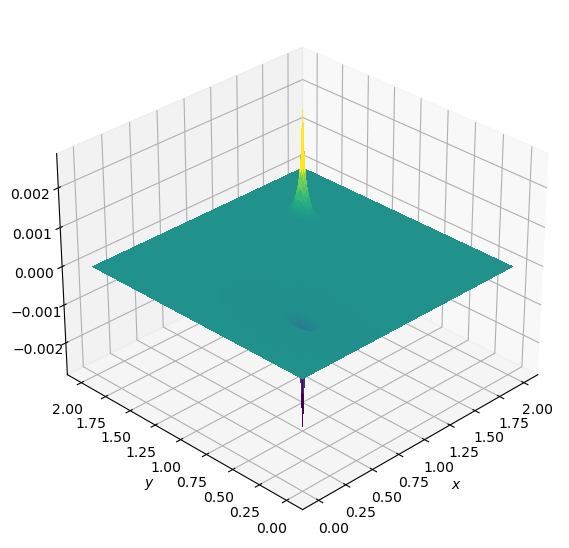

In [14]:
plot2D(x, y, p)

Ah ! Les merveilles de la réutilisation de code ! Maintenant, vous pensez probablement : "Eh bien, si j'ai écrit cette petite fonction qui fait quelque chose d'aussi utile, je veux l'utiliser encore et encore. Comment puis-je faire cela sans copier et coller à chaque fois ? - Si vous êtes très curieux à ce sujet, vous devrez vous renseigner sur le *packaging*. Mais cela dépasse le cadre de nos leçons CFD. Vous n'aurez qu'à chercher sur Google si vous voulez vraiment savoir.

***

##  Pour aller plus loin ...

Pour en savoir plus sur le rôle de l'équation de Poisson dans la CFD, regardez la **Leçon vidéo 11** sur You Tube :

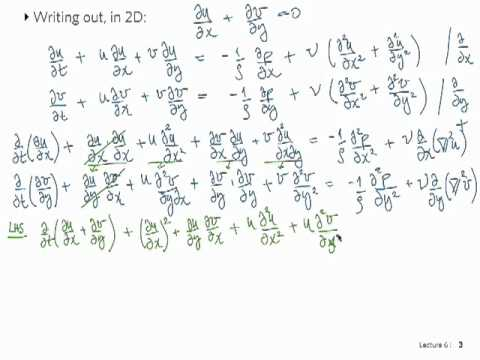

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZjfxA3qq2Lg')

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()